In [1]:
%reload_ext autoreload
%autoreload 2

import sys, os, time
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from pyod.models.knn import KNN
from sklearn.metrics import f1_score

from TrADe import *
from source_target_pair import *

def ignore_warnings():
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    warnings.simplefilter(action='ignore', category=Warning)

ignore_warnings()

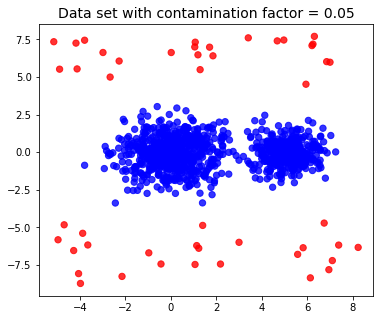

In [2]:
np.random.seed(331)
n = 1000
class_prior = 0.95 #real class prior
contamination = 1-class_prior

#Training set
a1_ = np.random.randn(2, np.int(n*(1-class_prior)/6))#*0.6
a2_ = np.random.randn(2, np.int(n*(1-class_prior)/6))#*0.6
a3_ = np.random.randn(2, np.int(n*(1-class_prior)/6))#*0.6
a4_ = np.random.randn(2, np.int(n*(1-class_prior)/6))#*0.6
a5_ = np.random.randn(2, np.int(n*(1-class_prior)/6))#*0.6
a6_ = np.random.randn(2, np.int(n*(1-class_prior)/6))#*0.6
num_anom = a1_.shape[1] + a2_.shape[1]+ a3_.shape[1] + a4_.shape[1] + a5_.shape[1]+ a6_.shape[1]

d1_ = np.random.randn(2, np.int(n*0.6))*1.1
n_ = n - d1_.shape[1] - num_anom
d2_ = np.random.randn(2, n_)*0.8

d2_[0, :] += 5

a1_[0, :] += 6.5
a1_[1, :] -= 6.5
a2_[0, :] -= 4.
a2_[1, :] -= 6.5
a3_[0, :] += 1.
a3_[1, :] -= 6.5
a4_[0, :] += 6.5
a4_[1, :] += 6.5
a5_[0, :] -= 4.
a5_[1, :] += 6.5
a6_[0, :] += 1.5
a6_[1, :] += 6.5


data_set = np.concatenate((a1_, a2_, a3_, a4_,a5_, a6_, d1_, d2_), axis=1)
X = data_set.T
y = np.zeros(n, dtype=np.int)
y[:num_anom] = +1

#Plot training and test sets
fig = plt.figure(figsize=(6, 5), facecolor='w', edgecolor='k')
colors = np.array(['b' if y[i] == 0 else 'r' for i in range(n)])# ['g', 'r'])
plt.scatter(X.T[0],X.T[1], 40, colors, alpha = 0.8)
plt.title("Data set with contamination factor = "+str(round(1-class_prior, 2)), fontsize=14)
plt.show()

In [3]:
seed = 331
X_s, y_s, X_t, y_t = split_biased_domains(X, y, n_clust = 5, source_prop = .8, seed = seed)
s_gamma = sum(y_s)/len(y_s)
t_gamma = sum(y_t)/len(y_t)
s_ad = KNN(n_neighbors = 25, contamination = s_gamma).fit(X_s)
t_ad = KNN(n_neighbors = 25).fit(X_t)

s_scores, t_scores, s_lambda = normalizeScoresLambda(s_ad, t_ad, s_gamma, seed = seed, noise = False)

gamma_Tm = TrADe(s_scores, t_scores, s_lambda, seed = seed)
print(gamma_Tm, t_gamma)

0.16379310344827586 0.17672413793103448


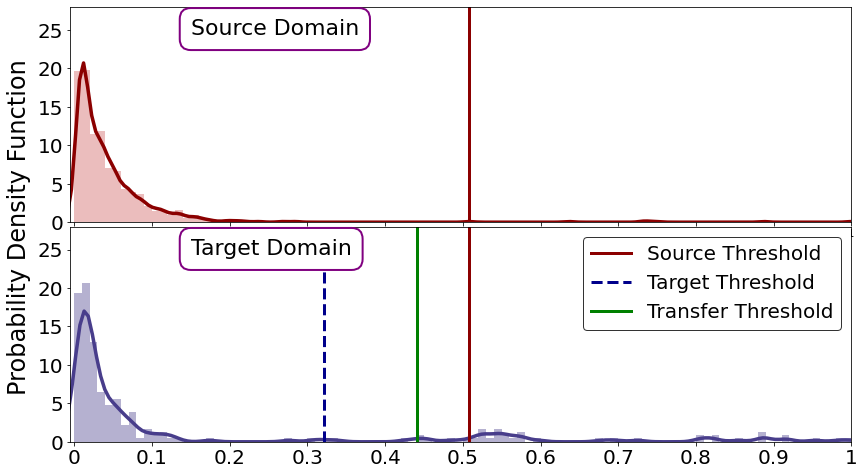

In [4]:
# True threshold lambda
t_anomalies = int(t_gamma*len(t_scores))
idx = np.argpartition(t_scores, -t_anomalies)[-t_anomalies:]  # Indices not sorted
t_lambda = t_scores[idx[np.argmin(t_scores[idx])]]

# Estimated threshold lambda
trade_anomalies = int(gamma_Tm*len(t_scores))
idx = np.argpartition(t_scores, -trade_anomalies)[-trade_anomalies:]  # Indices not sorted
lambda_Tm = t_scores[idx[np.argmin(t_scores[idx])]]
    
    
kde_kws_source={'bw':.08,"color": "darkred", "lw": 3.5}
kde_kws_target={'bw':.04,"color": "darkslateblue", "lw": 3.5}

fig = plt.figure(figsize=(14, 8), facecolor='w', edgecolor='k')
ax = plt.subplot(2,1,1)
sns.distplot(s_scores, bins = 100, hist = True, color= 'indianred', kde_kws=kde_kws_source)
plt1 = plt.axvline(s_lambda,ymin = 0, ymax = 5, lw = 3, color = 'darkred')
ax.xaxis.set_label_coords(0.92,-0.08)
ax.set_xticks([],[])
plt.yticks(fontsize = 20)
plt.ylim(0,28)
plt.ylabel('')
#--------------------------------------------------------------------------------------------------------
plt.subplot(2,1,2, sharex = ax)
ax = sns.distplot(t_scores, bins = 100, hist = True, color= 'darkslateblue', kde_kws=kde_kws_target)
plt.ylabel('Probability Density Function',fontsize = 24)
plt.xlabel('Anomaly Scores',fontsize = 24)

plt.axvline(s_lambda,  ymin = 0, ymax = 5, lw = 3, color = 'darkred')
plt2 = plt.axvline(t_lambda,  ymin = 0, ymax = 5, lw = 3, color = 'darkblue', linestyle = '--')
plt3 = plt.axvline(lambda_Tm, ymin = 0, ymax = 5, lw = 3, color = 'green')

ax.xaxis.set_label_coords(0.9,-0.13)
ax.yaxis.set_label_coords(-0.05, 1)

plt.xlim(-0.005,1)
plt.xticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylim(0,28)

box = dict(boxstyle='round', facecolor='white', alpha=1, pad=0.5, lw=2, edgecolor='purple')

plt.text(.15, 52.9, 'Source Domain', fontsize=22, horizontalalignment='left', bbox=box)
plt.text(.15, 24.3, 'Target Domain', fontsize=22, horizontalalignment='left', bbox=box)


plt.legend((plt1, plt2, plt3),
           ('Source Threshold', 'Target Threshold', 'Transfer Threshold'),
           scatterpoints=1,
           loc='upper right',
           bbox_to_anchor=(1, 1),
           ncol=1,
           fontsize=20,frameon=True).get_frame().set_edgecolor('black')

plt.subplots_adjust(hspace = 0.02, wspace = 0.0)
#plt.savefig('domains_and_thresholds.pdf', format = 'pdf', bbox_inches = 'tight')

plt.show()
